In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import pprint
%matplotlib inline

In [139]:
data = pd.read_csv("./otodom/otodom.csv", sep=",")

In [140]:
data.shape

(36080, 44)

In [141]:
data.dtypes

ac                     float64
address                 object
alarm                  float64
antiburglary_blinds    float64
antiburglary_doors     float64
available_from          object
balcony                float64
building_material       object
building_status         object
building_type           object
cable_tv               float64
cellar                 float64
description             object
dish_washer            float64
duplex                 float64
floor                   object
fridge                 float64
furniture              float64
garage                 float64
garden                 float64
heating                 object
intercom               float64
internet               float64
lift                   float64
m2                      object
market                  object
max_floor               object
name                    object
oven                   float64
possession_type         object
price                   object
rent                    object
restrict

In [142]:
pd.set_option("display.max_columns",50)
data.describe()

,ac,alarm,antiburglary_blinds,antiburglary_doors,balcony,cable_tv,cellar,dish_washer,duplex,fridge,furniture,garage,garden,intercom,internet,lift,oven,restricted_area,security,separate_kitchen,stove,telephone,terrace,tv,usable_room,washing_machine,year
count,777.0,929.0,985.0,6844.0,22169.0,15000.0,14586.0,2639.0,1193.0,3725.0,6172.0,13751.0,2881.0,13277.0,16865.0,14293.0,4040.0,5907.0,6316.0,7090.0,4533.0,11171.0,3639.0,998.0,4618.0,2607.0,25280.000000
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1997.528244
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.656360
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1983.000000
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2010.000000
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2018.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20133.000000


# Data preprocessing

Changing variable year (year in which apartment was build) to be relative to current year

In [143]:
from datetime import datetime

now = datetime.now()
data["year"] = now.year - data["year"]

In [144]:
months = {" Stycznia ":".01.",
          " Lutego ":".02.",
          " Marca ":".03.",
          " Kwietnia ":".04.",
          " Maja ":".05.",
          " Czerwca ":".06.",
          " Lipca ":".07.",
          " Sierpnia ":".08.",
          " Września ":".09.",
          " Października ":".10.",
          " Listopada ":".11.",
          " Grudnia ":".12."
         }

for name, value in months.items():
     data["available_from"] = data["available_from"].str.replace(name, value)

data["available_from"] = data["available_from"].str.replace(" ","")        
data["available_from"] = data["available_from"].fillna("") #to replace empty floats with strings

In [145]:
def format_to_date(i, date_format):
    if i is not None and i != "":
        delta = datetime.strptime(str(i), date_format) - datetime.today()
        return (delta).days
    else:
        return None

In [146]:
date_format = "%d.%m.%Y"

data["available_from"] = [ format_to_date(i, date_format) for i in data["available_from"]]

Converting price variable from str to float.  
Removing empty values and rows with price is in foreign currencty to avoid currency exchange (there are only few of them so they are not so valuable)

In [147]:
data = data[~data["price"].str.contains("GBP|USD|EUR", na=False, regex=True)]
data["price"] = data["price"].str.replace(",", ".").str.replace(" ", "").str.replace("zł", "").astype(float)
data = data[pd.notnull(data["price"])]

Address variable - spliting into 3 parts (city, district and street)

In [148]:
data["address"] = data["address"].str.replace("Mieszkanie na sprzedaż,","")
address_df = data["address"].str.split(",", expand=True)
address_df.columns = ["city", "district", "street"]
data = data.drop(["address"], axis=1)
data = pd.concat([data, address_df], axis=1)

Converting m2 variable (area of apartment) from str to float.

In [149]:
data["m2"] = data["m2"].str.replace(" m²","").str.replace(",", ".").str.replace(" ", "").astype(float)

In [150]:
#plt.xlim(0,1000)
#data["m2"].plot.density()

Converting rent variabe (rent paid monthly for apartment) from str to float.

In [151]:
data["rent"] = data["rent"].str.replace(" zł","").str.replace(",", ".").str.replace(" ", "").astype(float)

Converting max_floor variable (number of floors in the buidling) from str to int.

In [152]:
data["max_floor"] = data["max_floor"].str.replace("\(z ","").str.replace("\)", "").astype(float)

Converting max_floor variable (number of floors in the buidling) from str to int.

In [153]:
data.loc[data["floor"]=="parter", "floor"] = 0
data.loc[data["floor"]=="> 10", "floor"] = 11
data.loc[data["floor"]=="suterena", "floor"] = -1
data.loc[data["floor"]=="poddasze", "floor"] = data["max_floor"] #assuming that value provided in max_floor variable is real
data["floor"] = data["floor"].astype(float)

Converting rooms_n variable (number of rooms in apartment) from str to int.

In [154]:
data.loc[data["rooms_n"]=="więcej niż 10", "rooms_n"] = 11
data["rooms_n"] = data["rooms_n"].astype(float)

Dropping varaiables which are insignificant for our model

In [155]:
data = data.drop(["description","name"], axis=1)

### Checking number of degrees in categorical variables and transforming values into separate columns
Variables building_material and building_type have values with insignificiant 

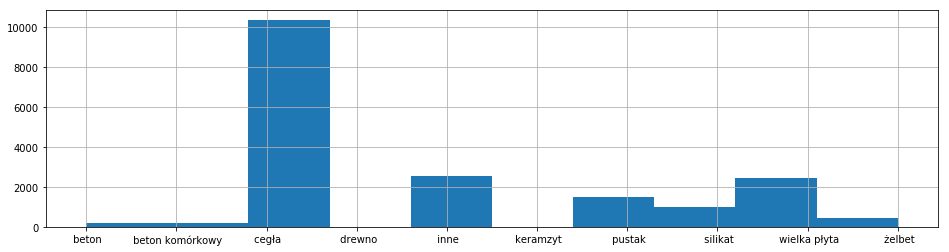

In [156]:
plt.rcParams["figure.figsize"] = [16.0, 4.0]
data["building_material"].hist()

In [157]:
data.loc[~data["building_material"].str.contains("cegła|wielka płyta|pustak", na=False, regex=True), 'building_material'] = 'inne'

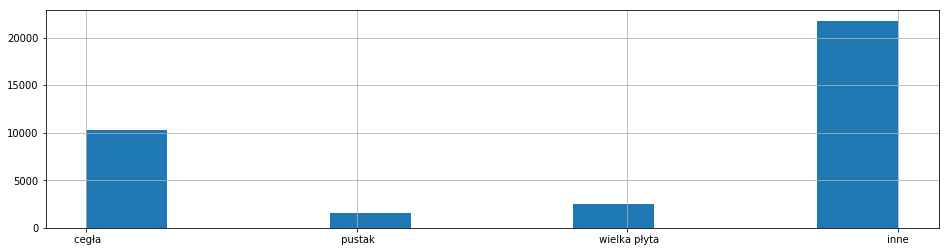

In [158]:
data["building_material"].hist()

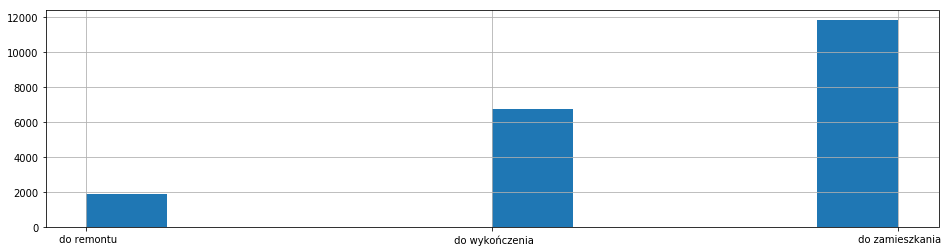

In [159]:
data["building_status"].hist()

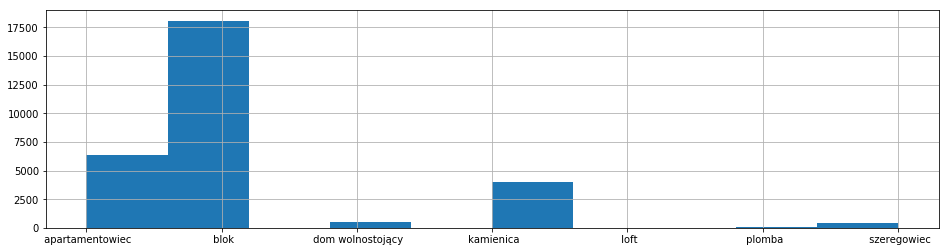

In [160]:
data["building_type"].hist()

In [161]:
data.loc[~data["building_type"].str.contains("blok|apartamentowiec|kamienica", na=False, regex=True), 'building_type'] = 'inne'

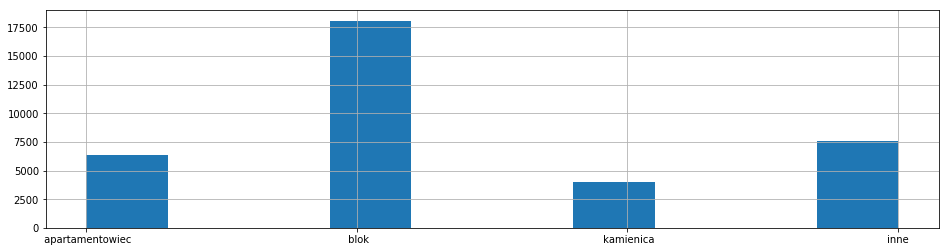

In [162]:
data["building_type"].hist()

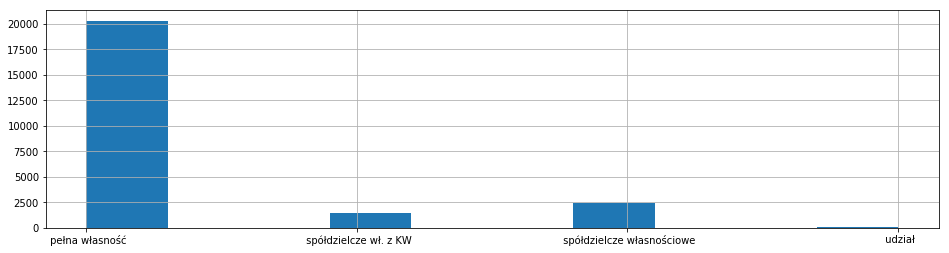

In [163]:
data["possession_type"].hist()

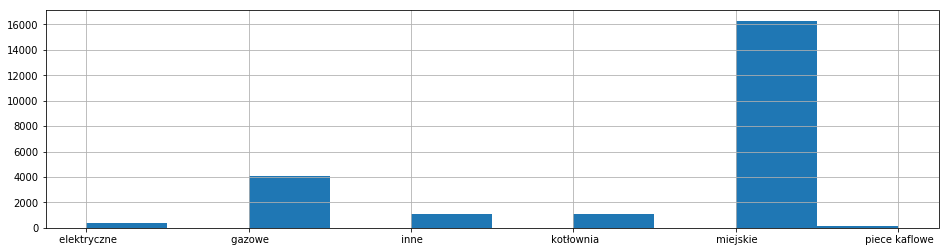

In [164]:
data["heating"].hist()

Removing spaces from values to avoid column names with spaces after applying get_dummies function.

In [165]:
data["building_material"] = data["building_material"].str.replace(" ","")
data["building_status"] = data["building_status"].str.replace(" ","")
data["building_type"] = data["building_type"].str.replace(" ","")
data["possession_type"] = data["possession_type"].str.replace(" ","")
data["heating"] = data["heating"].str.replace(" ","")

Imputing 0 in every bit column. Otodom website doesn't show 0 values for those columns (it's either 1 or NULL), so right now we are assuming that users provided true data :)

In [166]:
bit_columns = list(data.max().loc[data.max()==1].index)
data[bit_columns] = data[bit_columns].fillna(0).astype(int)

In [167]:
data = data.drop(["city","district","street"], axis=1)

Converting categorical variables into n

In [168]:
data = pd.get_dummies(data)

In [169]:
X = data.drop(["price"], axis=1)
y = data["price"]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [173]:
base = [
    ("imput", Imputer(strategy="mean", axis=0))#,
    #("scale", MinMaxScaler())  
]

models = [
    ("model",LinearRegression()),
    ("model",RandomForestRegressor())
    #[("model",XGBRegressor())]
]

param_grids = [{"model__normalize":[True,False]},
               {"model__n_estimators":[10,100,1000]}#{"model__n_estimators":[10,100,1000],"model__min_samples_leaf":[5,25,50,100],"model__max_depth":[5,10,15,25]}
]

False

In [175]:
best_models = []
#GridSearchCV doesn't allow NaNs so we have to imput missing data before grid search
imputer = Imputer(strategy="mean", axis=0)
X_train = pd.DataFrame(imputer.fit_transform(X_train))

for i, model in enumerate(models):
    
    steps = base.copy()
    steps.append(model)
    pipe = Pipeline(steps)

    gs = GridSearchCV(estimator=pipe, param_grid=param_grids[i])
    gs.fit(X_train,y_train)
    pprint.pprint(gs.cv_results_ )
    best_models.append((gs.best_params_,gs.best_estimator_))

{'mean_fit_time': array([ 0.05720798,  0.0527029 ]),
 'mean_score_time': array([ 0.0095067 ,  0.00850638]),
 'mean_test_score': array([-0.4613777 , -0.46127988]),
 'mean_train_score': array([ 0.41520681,  0.41520784]),
 'param_model__normalize': masked_array(data = [True False],
             mask = [False False],
       fill_value = ?)
,
 'params': [{'model__normalize': True}, {'model__normalize': False}],
 'rank_test_score': array([2, 1]),
 'split0_test_score': array([ 0.38958476,  0.38959746]),
 'split0_train_score': array([ 0.36980407,  0.36980428]),
 'split1_test_score': array([-1.92039147, -1.92023913]),
 'split1_train_score': array([ 0.46030111,  0.46030405]),
 'split2_test_score': array([ 0.14667362,  0.14680205]),
 'split2_train_score': array([ 0.41551524,  0.4155152 ]),
 'std_fit_time': array([ 0.00317225,  0.00429083]),
 'std_score_time': array([ 0.00070689,  0.00070734]),
 'std_test_score': array([ 1.03643374,  1.03639085]),
 'std_train_score': array([ 0.03694591,  0.0369470

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
model = LinearRegression()                  
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
print("R2: {}\n mse: {}".format(r2_score(y_test, model.predict(X_test))
                                ,mean_squared_error(y_test, model.predict(X_test)))
     )

R2: 0.3270432209875489
 mse: 129708638856.80284


In [37]:
model = RandomForestRegressor()                
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
print("R2: {}\n mse: {}".format(r2_score(y_test, model.predict(X_test))
                                ,mean_squared_error(y_test, model.predict(X_test)))
     )

R2: 0.6302399896284242
 mse: 71269164892.51537


In [44]:
model = XGBRegressor()                
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [45]:
print("R2: {}\n mse: {}".format(r2_score(y_test, model.predict(X_test))
                                ,mean_squared_error(y_test, model.predict(X_test)))
     )

R2: 0.642072059425591
 mse: 68988599905.1155


In [41]:
data.dtypes

ac                                              int32
alarm                                           int32
antiburglary_blinds                             int32
antiburglary_doors                              int32
available_from                                float64
balcony                                         int32
cable_tv                                        int32
cellar                                          int32
dish_washer                                     int32
duplex                                          int32
floor                                         float64
fridge                                          int32
furniture                                       int32
garage                                          int32
garden                                          int32
intercom                                        int32
internet                                        int32
lift                                            int32
m2                          